# FFP Intersections

Calculates the source area of Eddy Covariance observations using the Kljun et al. 2015 flux footprint (FFP) model and overlays the resulting outputs with an ecosystem classification map if one is provided.

## Required Inputs for FFP:

### 1. configuration.ini

Settings to run the FFP model - specifics are documented within the file itFFP.  The default settings should be sufficient for most use cases.  Key parameters that may need to be updated:

**[Input_Data]**

dpath: path to your input data.  Default is set to "FFP_Inputs/FP_Run.csv" - you can save your input data here or change the parameter in the .config file

**[Input_Variable_Names]**

Adjust these accordingly if your input data naming conventions do not match those expected - or rename the columns in you input data.  For UBC-micromet users: the highfreq/SITE/footprint folder contains half-hourly input data and a site configuration file for each site with names already set according to what the program expects.

### 2. Site configuration 

A .ini file with time "invariant" metadata about the site.  Most of these data can be parsed from a LICOR .ghg file, a script to do that is available [here](https://github.com/ubc-micromet/Biomet.net/blob/main/Python/MakeSpatialConfigFile.py).  Key variables in the site configuration include:

* **latitude & longitude**:  Must be in WGS 1984.  All data will be re-projected to UTM coordinates for the most accurate spatial referencing.

    + The FFP_Assessment.py program will automatically handle the re-projecting the data for you.  It will select the correct UTM zone based on lat/lon

* **canopy height**:  Canopy height should be provided here, but if the value varies over seasons/years it can be over-written by providing a time-variable canopy height with the input data.

* **Zm**: Measurement height above the **ground surface**.  The Kljun et al. 2015 FFP expects "Measurement height above displacement height (i.e. zm = z-d)".  However: the FFP_Assessment.py program will automatically handle this adjustment.

* **bearing**: Compass bearing in degrees from **geographic north** of the EC system


### 3. Input data 

The half-hourly (or hourly) data from the EC station.  The FFP will be calculated for each timestep in this file.

**Required Values**:

* **h**: Height of planetary boundary layer (m) - if not available, a function to download and extract from NARR data can be found [here](https://github.com/ubc-micromet/Biomet.net/blob/main/Python/ExtractNARR.py)

* **ol**: Obukhov length (m)

* **sigmav**: Standard deviation of horizontal wind (m/s)

* **ustar**: Friction velocity (m/s)

* **umean**: Mean wind speed (m/s) - *Note*: the program expects u-mean, but will only actually be used if FFP is run without z0 (see bellow)

* **wind_dir**: Wind direction in degrees from north (deg)

**Optional Values**:

* **canopy_height**: Plant canopy height (m) - Can be a dynamic value provided with time-variable input data if it changes over the observation period.

* **roughness length**: Can provide explicitly if known or leave blank to auto calculate as a fraction of canopy height (Assumptions in configuration file).  To run without z0 (using umean and the von-Karman constant instead): Leave blank **AND** edit the configuration.ini file to set:

    [Assumptions] 
    roughness_length = None 

* **Subset**: sub-periods to partition by.  Will create a separate FFP climatology (raster image + contours) for each sub-period.  Could be days, months, years, etc.  Could also do one for each time step - but if running for extended periods this will produce a **massive** amount of fairly useless outputs.   

### 4. Basemap 

Optionally input a landscape classification map.  The FFP will be overlaid with the map at each timestep to partition the source area (as a % contribution) by each class.

* **basemap**: - provide a path to either a shapefile (shp) or geojson (json).  FFP_Assessment.py program will automatically re-projecting the classification map for you and convert to a raster format for overlay with the FFP.

* **basemap class**: Name of a feature in the basemap by which to partition the FFP.  i.e., if your basemap is an ecosystem classification map and the header "ECO_CLASS" denoted that in the file, you would specify that here.  If you provide a basemap, without specifying this value, it will assume every polygon in the input file is a unique class and perform the overlay separately for each.


# Getting setup

Import some packages and inspect the configuration file

In [7]:
# For interactive plots - uncomment one of the below:
# %matplotlib ipympl - in VS code 
# %matplotlib notebook - if using a jupyter notebook

import numpy as np
import pandas as pd
import geopandas as gpd
import configparser
import matplotlib.pyplot as plt

# On my WSL Subsystem the highfreq drive is mapped as:
Highfreq_root = '/mnt/y'

# On windows he highfreq drive is mapped as:
Highfreq_root = 'Y:'

# Abbreviation for site
Site_Name = 'FishIsland'

# Site_Code = 'FishIsland_5m'

if Site_Code is None:
    Site_Code=Site_Name

# For UBC-micromet users: the highfreq/SITE/footprint folder contains half-hourly input data
# and a site configuration file for each site 
input_data = f'{Highfreq_root}/{Site_Name}/footprint/FFP_Inputs_{Site_Name}.csv'
# Site_Config = f'{Highfreq_root}/{Site_Name}/footprint/{Site_Name}.ini'FishIsland_5m
Site_Config = f'{Highfreq_root}/{Site_Name}/footprint/{Site_Name}.ini'
Basemap = f'{Highfreq_root}/{Site_Name}/footprint/Landscape_Classification.geojson'
Basemap_Class = 'Class'

# # Optional basemap, e.g., the BBECA eocsystem classification map
# if Site_Name in ['BB','BB2','BBS']:
#     Basemap = f'{Highfreq_root}/{Site_Name}/footprint/BBECA_Eco_Classification.geojson'
#     Basemap_Class = 'Code'
# else:
#     Basemap = None
#     Basemap_Class = None


print('FFP will be run for the following site:')
site = configparser.ConfigParser()
site.read(Site_Config)


if Site_Code not in site.keys():
    print('Provide valid Site_Name and corresponding configuration file')
else:
    print(Site_Code)
    for key,value in site[Site_Name].items():
        print(f'{key}:{value}')
    print()

FFP will be run for the following site:
FishIsland_5m
site_name:FishIsland
altitude:2
latitude:69.372278
longitude:-134.881089
canopy_height:.08
zm:2.87
bearing:35
time_zone:Etc/GMT+7
start_year:2017



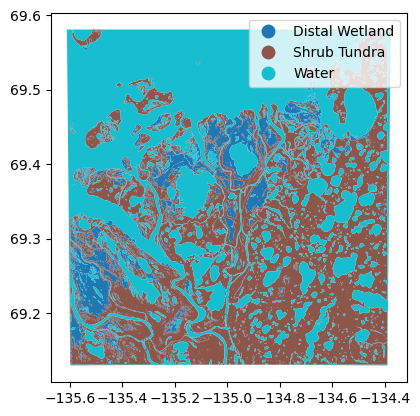

In [194]:
# # Make a web-compatible basemap from a shapfile
# # import geopandas as gpd

# gdf = gpd.read_file("PathToBasemapshp")
# gdf = gdf.to_crs('WGS84')
# gdf = gdf.rename(columns={'SOME_COLUMN_Label':'Class'})

# gdf.plot(column='Class',legend=True)
# gdf.to_file("PathToBasemap.shp.geojson", driver="GeoJSON")


import geopandas as gpd

# file = "G:\\Other computers\\My Laptop\\FishIsland_2017\\SiteInfo\\Classification\\LandscapeClass_Tweak.shp"
file = "Y:\\FishIsland\\footprint\\BigLake3Class.shp"
gdf = gpd.read_file(file)
gdf = gdf.to_crs('WGS84')
# gdf = gdf.rename(columns={'RenameTheDesiredColumTo':'Class'})

gdf.plot(column='Class',legend=True)
# gdf.shape

gdf.to_file(f'{Highfreq_root}/FishIsland/footprint/Landscape_Classification.geojson', driver="GeoJSON")

# Configuration

Check the config file

In [8]:

# FFP Configuration
ini = configparser.ConfigParser()
ini.read('configuration.ini')

print('FFP will be run with the following settings.  Edit the configuration.ini file to change them')
for head,section in ini.items():
    if len(section)>0:
        print(head)
        for key,value in section.items():
            print(f'{key}:{value}')
    print()


FFP will be run with the following settings.  Edit the configuration.ini file to change them

Input_Data
dpath:FFP_Inputs/FFP_Run.csv

Input_Variable_Names
canopy_height:canopy_height
z0:
h:hpbl
ol:L
sigmav:V_SIGMA
ustar:USTAR
umean:wind_speed
wind_dir:wind_dir

Output
dpath:Example_Outputs/
smoothing_factor:1

Multi_Processing
processes:4
batchsize:100

FFP_Parameters
domain:1000
dx:2
rs:.5,.75,.9
exclude_wake:30

Assumptions
roughness_length:0.15
displacement_height:0.67



## Pre processing

* Inspect the input data and setup a desired subsets (if not already existing).

In [178]:
# Read the input data
df = pd.read_csv(input_data,parse_dates=['datetime'],index_col='datetime')

# Correct any data and update units
df['canopy_height']*=.01

# Optionally, specify optional subset intervals.  For example
# If I wanted to see the FFP each season:

# Initialize subsets the name 'N/A' (will be excluded from calculations if not overwritten)
# df['Subset'] = 'N/A'

# # Define season by month
# Season = {"DJF":[12,1,2],
#           "MAM":[3,4,5],
#           "JJA":[6,7,8],
#           "SON":[9,10,11],
#           }

# df.loc[((df.index.dayofyear==202)),'Subset']='Run'

# # Select each season (note this subset is inclusive) but if want to exclude timestamps, just leave them as Subset = N/A
# for s,months in Season.items():
#     df.loc[((df.index.year-2021.5<=1)&(df.index.month.isin(months))),'Subset']=f'{s}'

# Save the input data to the expected location
df.to_csv('FFP_Inputs/FFP_Run.csv')

df.head()

,hpbl,L,V_SIGMA,USTAR,wind_speed,wind_dir,canopy_height,Subset
datetime,,,,,,,,
2017-06-23 15:00:00,321.050085,-40.913281,1.062623,0.471345,5.240248,112.465198,0.099075,N/A
2017-06-23 16:00:00,428.717954,-46.948937,1.147905,0.476375,5.730934,119.635376,0.099095,N/A
2017-06-23 17:00:00,536.385823,-39.630341,0.991713,0.430299,5.149514,118.907566,0.099114,N/A
2017-06-23 18:00:00,644.053692,-10.495185,0.968924,0.266934,3.018576,141.122392,0.099133,N/A
2017-06-23 19:00:00,825.976720,-16.043486,1.155106,0.281831,3.214696,123.082251,0.099153,N/A


# Inspect the basemap

EPSG:4326


,Class,Shape_Leng,Shape_Area,geometry
0,Distal Wetland,1.038381e+07,3.102295e+08,"MULTIPOLYGON (((-135.11713 69.13076, -135.1178..."
1,Shrub Tundra,7.473928e+06,9.880448e+08,"MULTIPOLYGON (((-134.73513 69.13098, -134.7347..."
2,Water,4.899178e+06,1.119806e+09,"MULTIPOLYGON (((-134.86344 69.13074, -134.8641..."


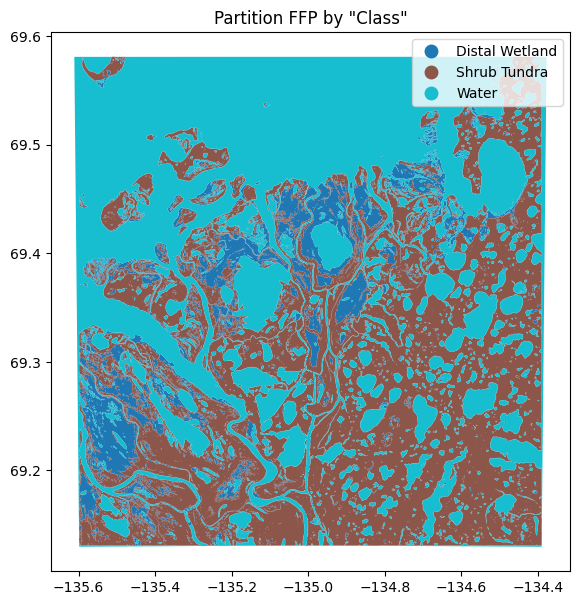

In [195]:
map = gpd.read_file(Basemap)
fig,ax=plt.subplots(figsize=(7,7))
map.plot(ax=ax,column=Basemap_Class,legend=True)
ax.set_title(f'Partition FFP by "{Basemap_Class}"')
print(map.crs)
map.head()

# Call the FFP Wrapper

* The FFP_Assessment.py script handles the initialization, re-projection, filtering for missing/invalid data, and multiprocessing
    + Submits half-hourly time-steps to Klujn_2015_Model.py, which calculates the FFP and does a per-time-step spatial overlay
* Returns the FFP - which is summed by interval and output to th specified output folder

In [196]:
import FFP_Asssment
import importlib
import time

importlib.reload(FFP_Asssment)

T1 = time.time()
# for n in [Site_Name,Site_Code]:
FFP = FFP_Asssment.RunClimatology(['Observed 2.9m','Estimated 5m'],Site_Config,Basemap=Basemap,Basemap_Class=Basemap_Class,
                                    # Subsets='Subset'
                                    )

print()
print('Total Runtime')
print((time.time() - T1)/60, ' minutes')

Rasterizing bassemap

Processing:   Observed 2.9m
6 records skipped: missing data
1 records skipped: low zm/ol
165 records skipped: low USTAR
176 records skipped: unacceptable wind_dir
Processing: 1644 out of 1966 input records for  Observed 2.9m
Processing FFP[██████████████████████████████████████████████████████████████] 1644/1644 191.5 Seconds elapsed

Processing:   Estimated 5m
6 records skipped: missing data
2 records skipped: low zm/ol
165 records skipped: low USTAR
176 records skipped: unacceptable wind_dir
Processing: 1644 out of 1966 input records for  Estimated 5m
Processing FFP[██████████████████████████████████████████████████████████████] 1644/1644 189.7 Seconds elapsed

Total Runtime
6.539745811621348  minutes


In [159]:
FFP.sub_name

'Run FishIsland_5m'

# Inspect the FFP Output

Text(0.5, 1.0, 'Full FFP Climatology')

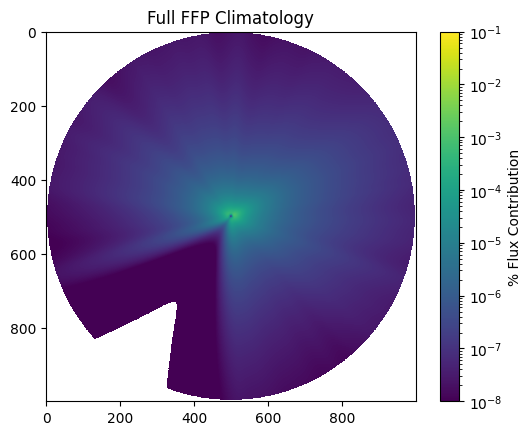

In [7]:
from matplotlib.colors import LogNorm


plt.figure()
plt.imshow(FFP.fclim_2d,norm=LogNorm(vmin=1e-8, vmax=1e-1))
plt.colorbar(label='% Flux Contribution')
plt.title('Full FFP Climatology')


Mean Source Area Fractions by Subset
Climatology
Collapse_Fc    0.03
Rim_Fc         0.25
Polygon_Fc     0.50
dtype: float64



,r,Interval,BandID,n_Obs,geometry,Area
0,0.50,Climatology,2,1966,"POLYGON ((504668.044 7695936.085, 504668.133 7...",10533.460047
1,0.75,Climatology,2,1966,"POLYGON ((504685.572 7695994.245, 504685.741 7...",45197.716226
2,0.90,Climatology,2,1966,"POLYGON ((504641.683 7696136.234, 504641.867 7...",214691.581065


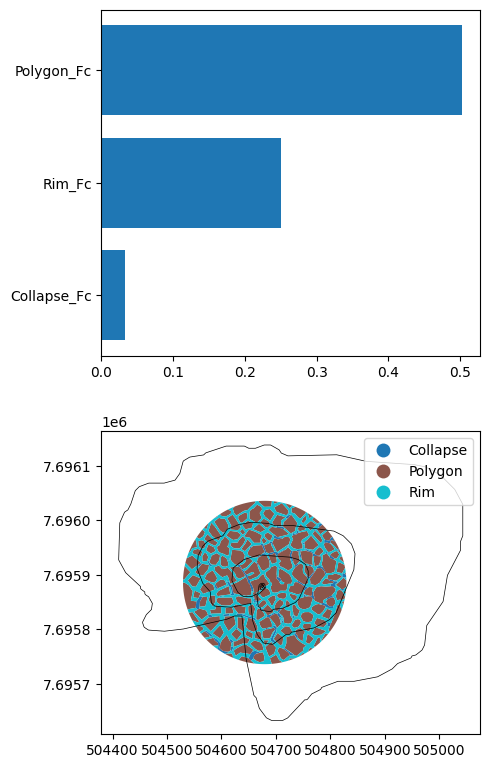

In [8]:
print('Mean Source Area Fractions by Subset')
for subset in FFP.Data['Subset'].unique():
    if subset != 'N/A':
        print(subset)
        Summary = FFP.Data.loc[FFP.Data['Subset']==subset,FFP.Fc_Names].mean().sort_values().round(2)
        if Summary.sum()>0:
            print(Summary)
        else:
            print('No Valid Outputs for Interval')
        print()
Mean_Source_Area = FFP.Data[FFP.Fc_Names].mean().sort_values()

fig,ax=plt.subplots(2,figsize=(5,8))

ax[0].barh(Mean_Source_Area.index,Mean_Source_Area)


FFP_Climatology = FFP.contour_levels.loc[FFP.contour_levels['Interval']=='Climatology']

FFP.baseVector.plot(ax=ax[1],column=Basemap_Class,legend=True)
FFP_Climatology.plot(ax=ax[1],color='None',edgecolor='k',linewidth=.5)

plt.tight_layout()


FFP.contour_levels.head()

# Display the webmap

This will only work in a jupyter notebook.  In VS code you have to render the html file directly.

* You may need to turn your vpn off to get the webmap to work properly

In [9]:
# from IPython.display import IFrame

# html_file = f"{FFP.ini['Output']['dpath']}{FFP.Site_Name}_FFP_{FFP.dx}m.html"

# IFrame(html_file, width=700, height=500)

In [10]:
import pandas as pd
import numpy as np
import plotly.express as px

SA = pd.read_csv('Example_Outputs/FFP_Source_Area_2m.csv',
                 parse_dates=['datetime'],index_col='datetime')

cols = SA.columns[SA.columns.str.contains('_Fc')]
Agg = SA.groupby('Subset').mean()[cols].round(2)
# Agg = SA[cols].mean().round(2)

Agg[Agg<.01]=np.nan
Agg= Agg.dropna(axis=1,how='all')
# # Agg= Agg.dropna()
Agg['Other']=1-Agg.sum(axis=1)
# Agg['Other']=1-Agg.sum()
Agg=Agg.rename(columns={'BS_Fc':'Beakrush-Sedge',
                    'BTW_Fc':'Beakrush-Threeway',
                    'PST_Fc':'Pine-Sphagnum'})
Agg = Agg*100
# Agg = pd.DataFrame(Agg).reset_index().rename(columns={'Subset':'Season',
#                                                       0:'Mean Flux Contribution'})
Agg.index.name = 'Season'

Agg = Agg.unstack().reset_index().rename(columns={'level_0':'Ecosystem Class',
                                                      0:'Mean Flux Contribution'})
Agg

# Agg = pd.DataFrame(Agg).reset_index().rename(columns={'index':'Ecosystem Class',
#                                                       0:'Mean Flux Contribution'})
fig = px.bar(Agg, 
            x="Mean Flux Contribution",
            y="Ecosystem Class",
            labels={'Mean Flux Contribution':'Flux Contribution by Source Area (%)'},
            orientation='h',
            color='Season',
            barmode='group',
            color_discrete_map = {'DJF':'blue',
                                  'MAM':'green',
                                  'JJA':'red',
                                  'SON':'purple'},
            title='Mean Flux Footprint Distribution by Ecosystem Type at Fish Island (2017 Growing Season)')
# fig.update_traces(marker_color=['blue','green','red','purple'])
fig.show()

fig.write_html("Example_Outputs/Summary_by_Basemap_Class.html")

In [11]:
import pandas as pd
import numpy as np
import plotly.express as px

SA = pd.read_csv('Example_Outputs/FFP_Source_Area_2m.csv',
                 parse_dates=['datetime'],index_col='datetime')

SA = SA.dropna()
SA['Other'] = 1-SA[['Rim_Fc','Polygon_Fc','Collapse_Fc']].sum(axis=1)
SA = SA[['Rim_Fc','Polygon_Fc','Collapse_Fc','Other']]
SA = SA.rename(columns={'Rim_Fc':'Polygon Rims',
                    'Polygon_Fc':'Polygons',
                    'Collapse_Fc':'Degraded Rims'})
SA['Timestamp'] = SA.index.strftime("%m-%d-%Y, %H:%M")
SA = SA.melt(id_vars=['Timestamp']).rename(columns={'variable':'Ecosystem Class',
                                        'value':'Mean Flux Contribution'})
fig = px.box(SA, 
            x="Mean Flux Contribution",
            y="Ecosystem Class",
            labels={'Mean Flux Contribution':'Flux Contribution by Source Area (%)'},
            orientation='h',
            # color='Season',
            # color_discrete_map = {'DJF':'blue',
            #                       'MAM':'green',
            #                       'JJA':'red',
            #                       'SON':'purple'},
            hover_data=[SA['Timestamp']],
            title='Flux Footprint Source Area Fractions by Ecosystem Type at Fish Island (2017 Growing Season)')
fig.show()

fig.write_html("Example_Outputs/Summary_by_Basemap_Class.html")